In [ ]:
import requests
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pandas.plotting import scatter_matrix
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

## API call

In [ ]:
start_date = datetime.date(2004, 3, 1)
end_date = datetime.date(2005, 4, 1)
url = "https://www.airnowapi.org/aq/forecast/latLong/?"

params = {
    "format": "application/json",
    "latitude": 39.5501,
    "longitude": -105.7821,
    "distance": 500,
    "API_KEY": "9F095D1F-395A-4E43-9A3C-609938C2B224" #dummy API key
}

# Initialize an empty list to store the results
all_data = []

# Looping through the dates and make API calls
current_date = start_date
while current_date < end_date:
    # Update the date parameter in the params dictionary
    params["date"] = current_date.strftime('%Y-%m-%d')

    # Make the API call and retrieve data
    response = requests.get(url, params=params)

    # Checking if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        data = json.loads(response.text)
        # Append the retrieved data to all_data
        all_data.append(data)
    else:
        print(f"Failed to fetch data for date: {current_date}")

    # Increment the current_date for the next iteration
    current_date += datetime.timedelta(days=1)

# Process the all_data list
df= pd.DataFrame(all_data)
df.to_csv('air_quality_index.csv', index=False)

## Reading the generated dataframe from API

In [ ]:
air_quality_data=pd.read_csv('air_quality_index.csv',sep=";")
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


## Data Cleaning

##Dropping the columns that are not required, renaming columns and changing the datatypes according to our requirement

In [ ]:
air_quality_data=air_quality_data.drop(columns=['Unnamed: 15','Unnamed: 16'])
air_quality_data.dropna(how='all',inplace=True) #since last few rows are only Na's we are dropping them.
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [ ]:
#renaming the columns for better understanding
air_quality_data=air_quality_data.rename(columns={"CO(GT)": "Carbon Monoxide","PT08.S1(CO)":"Tin Oxide",
                       "NMHC(GT)":"Non Metanic HydroCarbons",
                       "C6H6(GT)":"Benzene","PT08.S2(NMHC)":"Titania",
                       "NOx(GT)":"Nitrogen Oxides",
                      "PT08.S3(NOx)":"Tungsten Oxide (NOx targeted)",
                       "NO2(GT)":"Nitrogen Dioxide","PT08.S4(NO2)":"Tungsten Oxide (NO2 targeted)",
                      "PT08.S5(O3)":"Indium Oxide (O3)","T":"Temperature in Â°C",
                       "RH":"Relative Humidity (%)","AH":"Absolute Humidity"})
air_quality_data.head(5)

,Date,Time,Carbon Monoxide,Tin Oxide,Non Metanic HydroCarbons,Benzene,Titania,Nitrogen Oxides,Tungsten Oxide (NOx targeted),Nitrogen Dioxide,Tungsten Oxide (NO2 targeted),Indium Oxide (O3),Temperature in Â°C,Relative Humidity (%),Absolute Humidity
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [ ]:
air_quality_data.dtypes #checking the data types

Date                              object
Time                              object
Carbon Monoxide                   object
Tin Oxide                        float64
Non Metanic HydroCarbons         float64
Benzene                           object
Titania                          float64
Nitrogen Oxides                  float64
Tungsten Oxide (NOx targeted)    float64
Nitrogen Dioxide                 float64
Tungsten Oxide (NO2 targeted)    float64
Indium Oxide (O3)                float64
Temperature in Â°C                object
Relative Humidity (%)             object
Absolute Humidity                 object
dtype: object

In [ ]:
#replacing ',' with '.' in numerical columns
air_quality_data['Carbon Monoxide'] = air_quality_data['Carbon Monoxide'].astype(str).str.replace(',', '.')
air_quality_data['Benzene'] = air_quality_data['Benzene'].astype(str).str.replace(',', '.')
air_quality_data['Temperature in Â°C'] = air_quality_data['Temperature in Â°C'].astype(str).str.replace(',', '.')
air_quality_data['Relative Humidity (%)'] = air_quality_data['Relative Humidity (%)'].astype(str).str.replace(',', '.')
air_quality_data['Absolute Humidity'] = air_quality_data['Absolute Humidity'].astype(str).str.replace(',', '.')


#chamging the datatypes of the columns
air_quality_data['Carbon Monoxide'] = pd.to_numeric(air_quality_data['Carbon Monoxide'], errors='coerce')
air_quality_data['Benzene'] = pd.to_numeric(air_quality_data['Benzene'], errors='coerce')
air_quality_data['Temperature in Â°C'] = pd.to_numeric(air_quality_data['Temperature in Â°C'], errors='coerce')
air_quality_data['Relative Humidity (%)'] = pd.to_numeric(air_quality_data['Relative Humidity (%)'], errors='coerce')
air_quality_data['Absolute Humidity'] = pd.to_numeric(air_quality_data['Absolute Humidity'], errors='coerce')

air_quality_data['Date'] = air_quality_data['Date'].astype(str)
air_quality_data['Time'] = air_quality_data['Time'].astype(str)

#combining date and time columns to create one single column datetime
air_quality_data['Time'] = air_quality_data['Time'].str.replace(':', '.')
air_quality_data['DateTime'] = pd.to_datetime(air_quality_data['Date'] + ' ' + air_quality_data['Time'], format='%d/%m/%Y %H.%M.%S', dayfirst = True)

#dropping unwanted columns.
air_quality_data=air_quality_data.drop(columns=['Date','Time','Temperature in Â°C','Non Metanic HydroCarbons'])

air_quality_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Carbon Monoxide                9357 non-null   float64       
 1   Tin Oxide                      9357 non-null   float64       
 2   Benzene                        9357 non-null   float64       
 3   Titania                        9357 non-null   float64       
 4   Nitrogen Oxides                9357 non-null   float64       
 5   Tungsten Oxide (NOx targeted)  9357 non-null   float64       
 6   Nitrogen Dioxide               9357 non-null   float64       
 7   Tungsten Oxide (NO2 targeted)  9357 non-null   float64       
 8   Indium Oxide (O3)              9357 non-null   float64       
 9   Relative Humidity (%)          9357 non-null   float64       
 10  Absolute Humidity              9357 non-null   float64       
 11  DateTime              

In [ ]:
#final columns in dataframe
air_quality_data = air_quality_data[['DateTime', 'Carbon Monoxide', 'Tin Oxide',
       'Benzene', 'Titania', 'Nitrogen Oxides',
       'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity']]


In [ ]:
air_quality_data

,DateTime,Carbon Monoxide,Tin Oxide,Benzene,Titania,Nitrogen Oxides,Tungsten Oxide (NOx targeted),Nitrogen Dioxide,Tungsten Oxide (NO2 targeted),Indium Oxide (O3),Relative Humidity (%),Absolute Humidity
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,29.3,0.7568
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,23.7,0.7119
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,18.3,0.6406
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,13.5,0.5139


## Handling missing values

In [ ]:
air_quality_data = air_quality_data.replace(-200,np.nan) #observed that missing values were replaced by -200
air_quality_data.isnull().sum()

DateTime                            0
Carbon Monoxide                  1683
Tin Oxide                         366
Benzene                           366
Titania                           366
Nitrogen Oxides                  1639
Tungsten Oxide (NOx targeted)     366
Nitrogen Dioxide                 1642
Tungsten Oxide (NO2 targeted)     366
Indium Oxide (O3)                 366
Relative Humidity (%)             366
Absolute Humidity                 366
dtype: int64

In [ ]:
air_quality_data.set_index('DateTime', inplace=True)
air_quality_data = air_quality_data.interpolate(method='time') #using interpolation to fill in the missing values
air_quality_data=air_quality_data.reset_index()
air_quality_data.isnull().sum()


DateTime                         0
Carbon Monoxide                  0
Tin Oxide                        0
Benzene                          0
Titania                          0
Nitrogen Oxides                  0
Tungsten Oxide (NOx targeted)    0
Nitrogen Dioxide                 0
Tungsten Oxide (NO2 targeted)    0
Indium Oxide (O3)                0
Relative Humidity (%)            0
Absolute Humidity                0
dtype: int64

## Identifying and Handling Outliers

Now, for in detail analysis of outliers, we plot the boxplot of each parameter in the dataset.

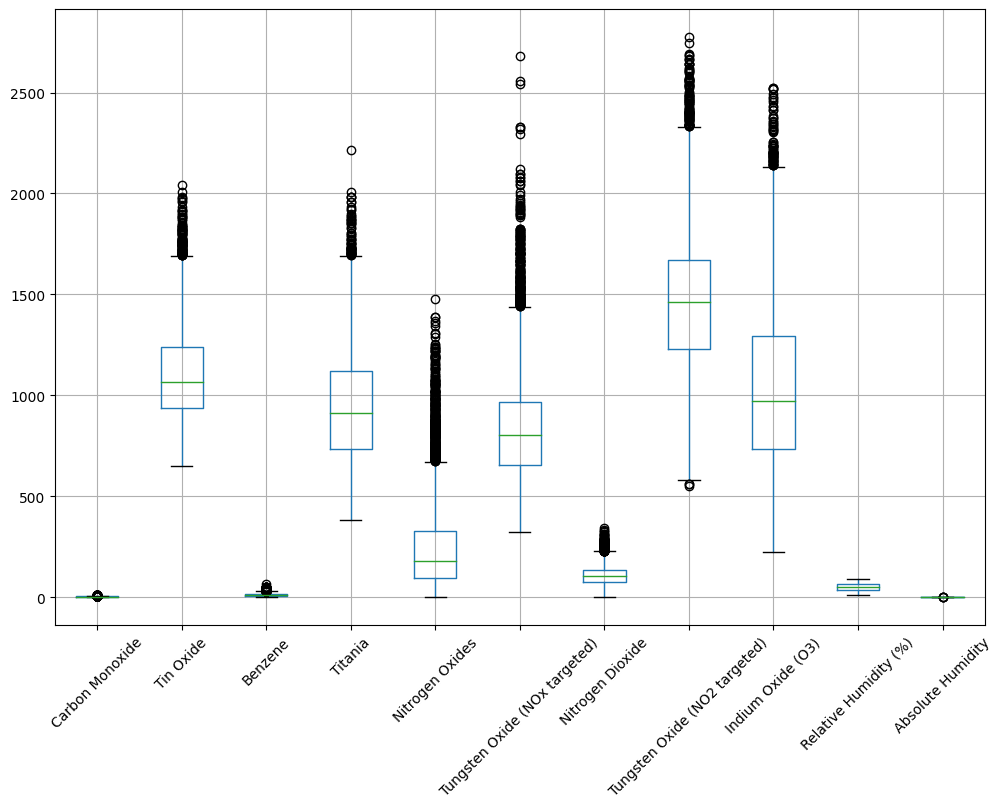

In [ ]:
air_quality_data.boxplot()
plt.gcf().set_size_inches(12, 8)
plt.xticks(rotation=45)
plt.show()

As we can notice that there are a lot of data points which lies outside the whiskers. Let's get a count of the outliers present in each column.<br>
Calculating the IQR,

In [ ]:
Q1 = air_quality_data.quantile(0.25)
Q3 = air_quality_data.quantile(0.75)
IQR = Q3 - Q1
IQR

DateTime                         194 days 22:00:00
Carbon Monoxide                                1.8
Tin Oxide                                    301.0
Benzene                                        9.6
Titania                                      383.0
Nitrogen Oxides                              230.0
Tungsten Oxide (NOx targeted)                314.0
Nitrogen Dioxide                         60.314685
Tungsten Oxide (NO2 targeted)                441.0
Indium Oxide (O3)                            560.0
Relative Humidity (%)                         26.5
Absolute Humidity                           0.5744
dtype: object

If the values fall below Q1 - (1.5 * IQR) or above Q3 + (1.5 * IQR), the

we consider it as an outlier.

In [ ]:
air_quality_data.columns

Index(['DateTime', 'Carbon Monoxide', 'Tin Oxide', 'Benzene', 'Titania',
       'Nitrogen Oxides', 'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity'],
      dtype='object')

In [ ]:
#removing the datetime column and creating a new dataframe to calculate the IQR values
air_quality_data1=air_quality_data[['Carbon Monoxide', 'Tin Oxide', 'Benzene', 'Titania',
       'Nitrogen Oxides', 'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity']]

In [ ]:
((air_quality_data1 < (Q1 - 1.5 * IQR)) | (air_quality_data1 > (Q3 + 1.5 * IQR))).sum()

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

To handle outliers we can follow three steps:

- Trimming or removing outliers permanently.
- Quantile based flooring and capping.
- Replacing them with mean and median.

Our approach:

- Trimming and removing outliers won't help much and may also results in data loss.
- Quantile based flooring and capping refer to replacing outliers with 10% and 90% quantile value.
- As mean value is highly influenced by the outliers, it been advised to use median to replace the outliers.

In [ ]:
mask = (air_quality_data1 < (Q1 - 1.5 * IQR)) | (air_quality_data1 > (Q3 + 1.5 * IQR))

air_quality_data1=air_quality_data1

for i in mask.columns:
    air_quality_data1[i].astype('float')
    temp = air_quality_data1[i].median()
    air_quality_data1.loc[mask[i], i] = temp

((air_quality_data1 < (Q1 - 1.5 * IQR)) | (air_quality_data1 > (Q3 + 1.5 * IQR))).sum()

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

Now, plotting the boxplot again, we see.

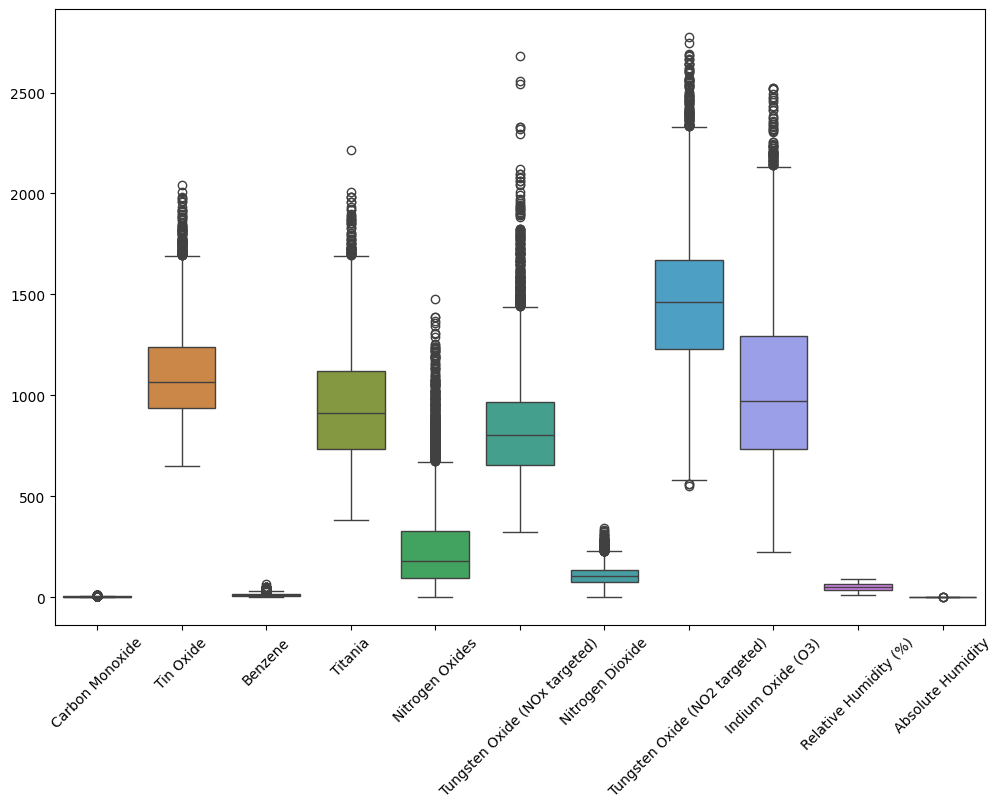

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=air_quality_data1)
plt.xticks(rotation=45)
plt.show()

## Checking for highly correlated values

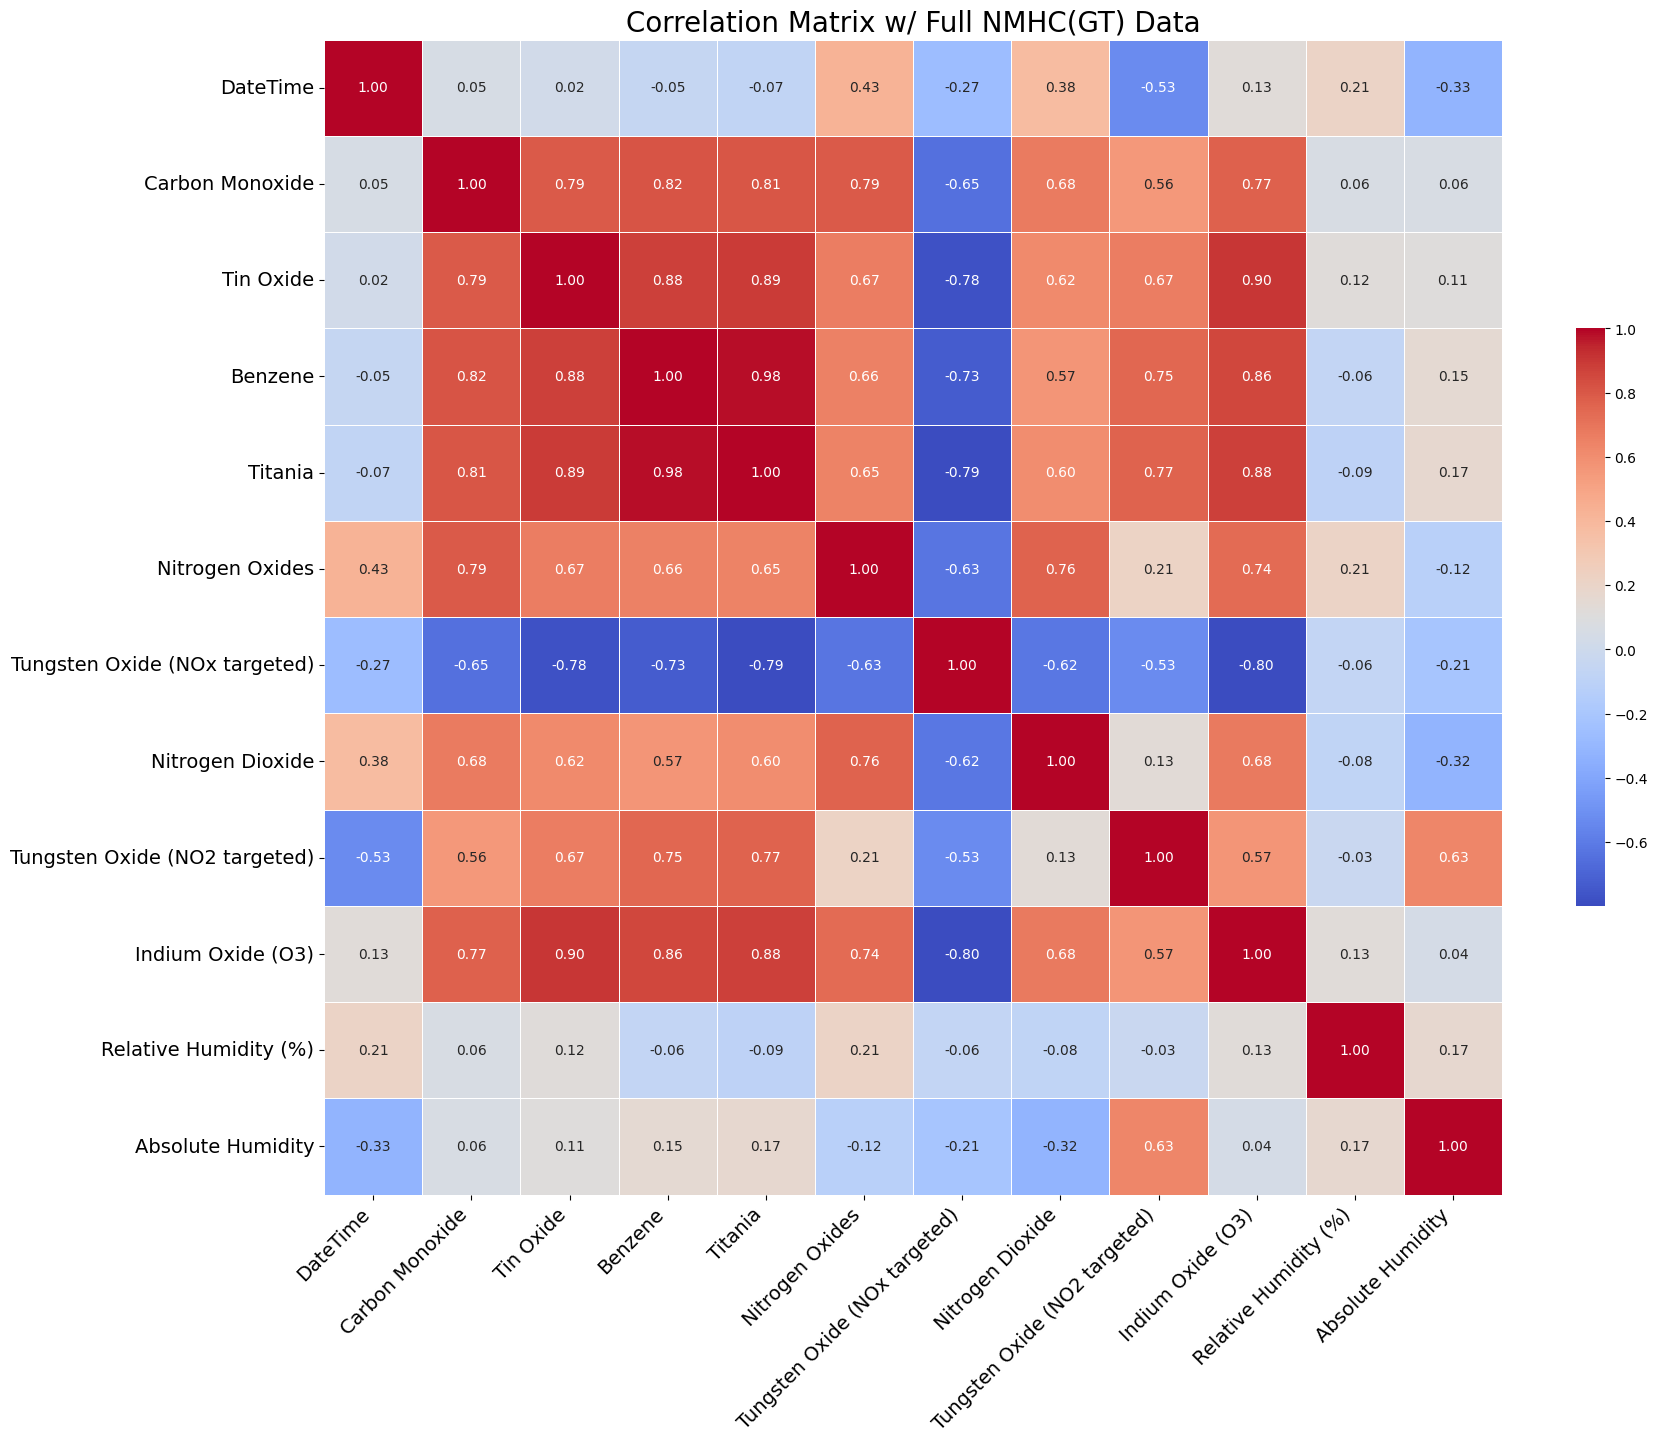

In [ ]:
corr = air_quality_data.corr()

f, ax = plt.subplots(figsize=(19, 15))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Matrix w/ Full NMHC(GT) Data', fontsize=20)
plt.show()

## Calculating Target variable AQI based on O3 values

Formula to calculate the AQI value based on the available air components is taken from the web

In [ ]:
import pandas as pd

# function to calculate AQI for O3
def calculate_aqi_o3(o3_concentration):
    # Breakpoints and AQI values for O3 based on the given range
    breakpoints = [0,450, 750, 1500, 2500, 3500, 4500,6000]
    aqi_values = [0, 50, 100, 150, 200,  300, 400, 500]

    # Initialize default values for aqi_low and aqi_high
    aqi_low = 0
    aqi_high = 0
    conc_low = 0
    conc_high = 0
    # Determine the AQI category based on concentration
    for i in range(len(breakpoints) - 1):
        if breakpoints[i] <= o3_concentration <= breakpoints[i + 1]:
            aqi_low = aqi_values[i]
            aqi_high = aqi_values[i + 1]
            conc_low = breakpoints[i]
            conc_high = breakpoints[i + 1]
            break
    if conc_high - conc_low == 0:
      return aqi_low
    # Linear interpolation formula
    aqi = ((aqi_high - aqi_low) / (conc_high - conc_low)) * (o3_concentration - conc_low) + aqi_low
    return round(aqi)


# Apply the function to the DataFrame column and create a new column for AQI
air_quality_data1['O3_AQI'] = air_quality_data1['Indium Oxide (O3)'].apply(calculate_aqi_o3)

# Print the DataFrame with AQI values
air_quality_data1


,Carbon Monoxide,Tin Oxide,Benzene,Titania,Nitrogen Oxides,Tungsten Oxide (NOx targeted),Nitrogen Dioxide,Tungsten Oxide (NO2 targeted),Indium Oxide (O3),Relative Humidity (%),Absolute Humidity,O3_AQI
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,135
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,115
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,122
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,130
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,124
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,29.3,0.7568,161
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,23.7,0.7119,135
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,18.3,0.6406,123
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,13.5,0.5139,101


## Data Visualization

###1.Weekly Granularity of the air components

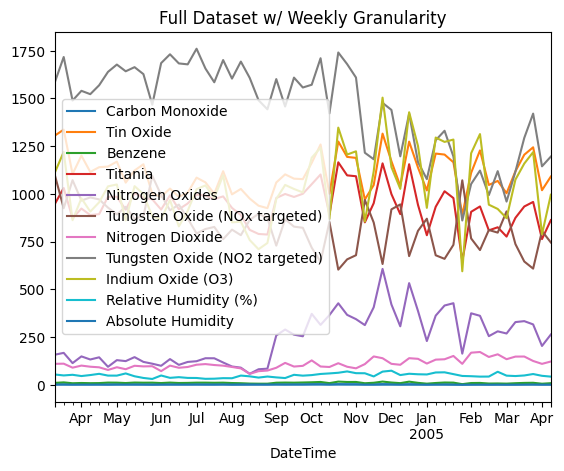

In [ ]:
air_quality_data.set_index('DateTime', inplace=True)
weekly = air_quality_data.resample('W').mean()
weekly.plot(title = "Full Dataset w/ Weekly Granularity")
plt.show()

**Weekly averaged data** reaffirms matrix observations:

- Four out of five sensors show correlation with NOx and NO2 target analytes.
- 'PT08.S3(NOx)' exhibits a negative correlation with all other sensors and target analytes

### 2 - Target Analysis

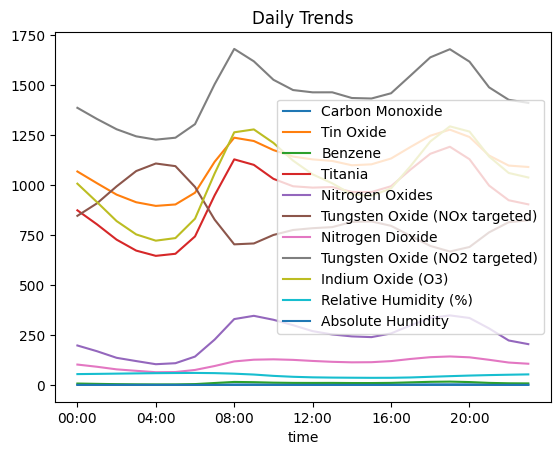

In [ ]:
by_time = air_quality_data.groupby(air_quality_data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, title = 'Daily Trends')
air_quality_data=air_quality_data.reset_index()
plt.show()


**Daily Trends**
NOx and NO2 levels peak at the start and end of a typical workday. The sensor array effectively captures these fluctuations.

### 3 - Histograms

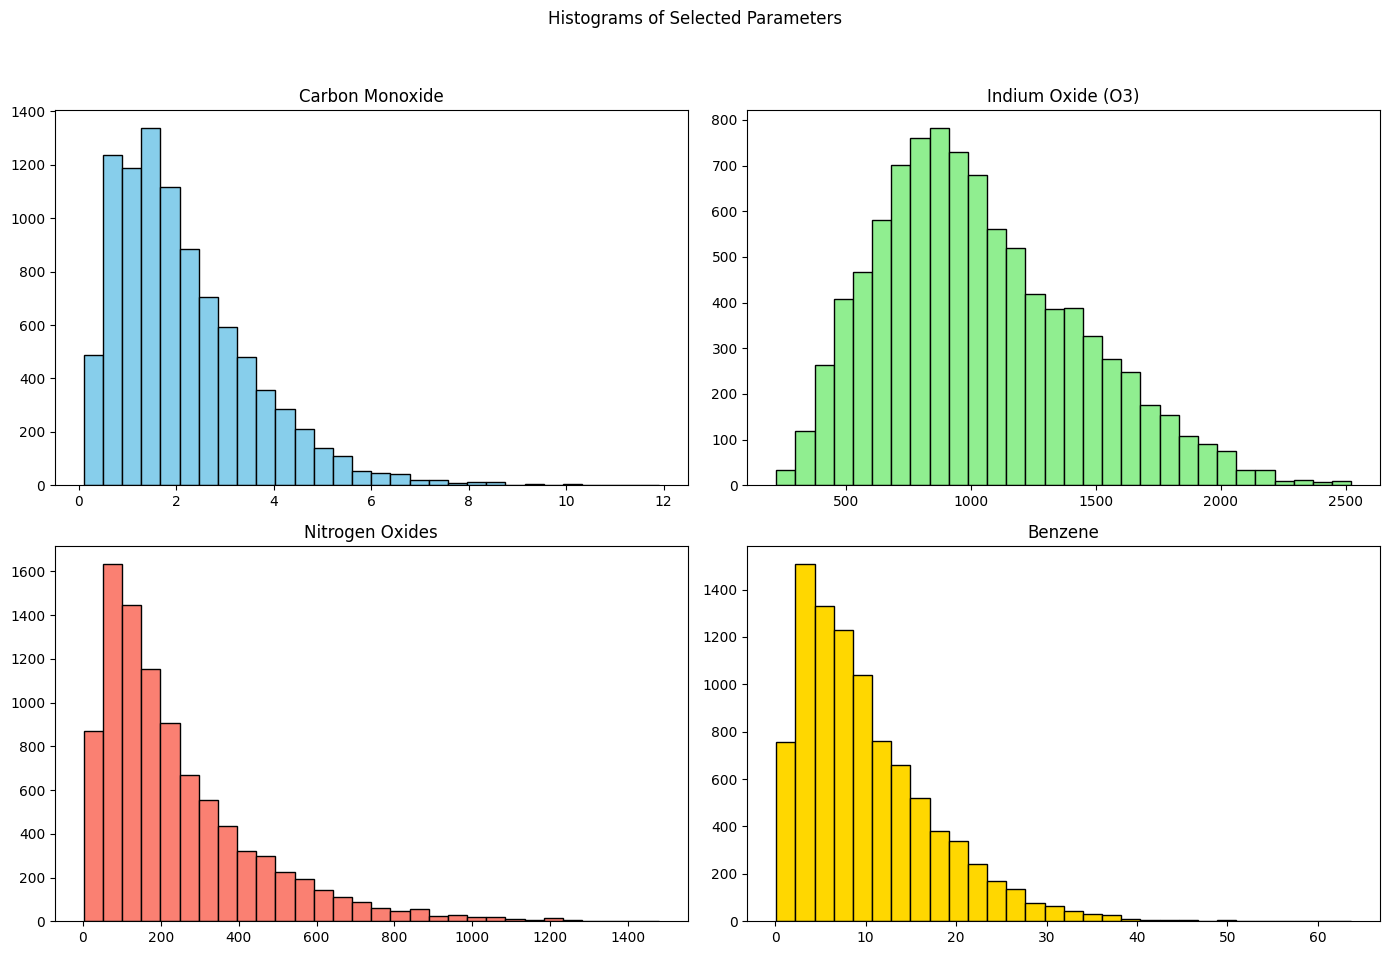

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Histograms of Selected Parameters')

# Carbon Monoxide
axes[0, 0].hist(air_quality_data1['Carbon Monoxide'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Carbon Monoxide')

# Indium Oxide (O3)
axes[0, 1].hist(air_quality_data1['Indium Oxide (O3)'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Indium Oxide (O3)')

# Nitrogen Oxides
axes[1, 0].hist(air_quality_data1['Nitrogen Oxides'], bins=30, color='salmon', edgecolor='black')
axes[1, 0].set_title('Nitrogen Oxides')

# Benzene
axes[1, 1].hist(air_quality_data1['Benzene'], bins=30, color='gold', edgecolor='black')
axes[1, 1].set_title('Benzene')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observations:-

- Carbon Monoxide: Most values are concentrated between 0 and 2.5, with a right-skewed distribution indicating that higher concentrations are less common.
- Indium Oxide (O3): This parameter shows a more symmetrical distribution, peaking around 750-1000, suggesting a more normal distribution of values.
- Nitrogen Oxides: The histogram reveals a right-skewed distribution, with most values concentrated in the lower range, indicating that higher concentrations of nitrogen oxides are less frequent.
- Benzene: Like Nitrogen Oxides, Benzene shows a right-skewed distribution with most values concentrated towards the lower end.

### 4 - Scatter plots

Using the correlation matrix, we can choose parameters which have high correlation for scatter plot. <br>

- Carbon Monoxide vs Benzene: Shows a dispersed but positive trend, suggesting as Carbon Monoxide levels increase, Benzene levels tend to increase as well.
- Tin Oxide vs Benzene: Displays a more defined positive correlation, indicating a strong relationship between the two. As Tin Oxide levels rise, so do Benzene levels.
- Indium Oxide (O3) vs Nitrogen Dioxide: This plot also shows a positive trend, albeit with a wide spread of data points, suggesting variability in how these two pollutants relate.
- Nitrogen Oxides vs Nitrogen Dioxide: Exhibits a clear positive correlation, indicating a strong linear relationship between the concentrations of Nitrogen Oxides and Nitrogen Dioxide

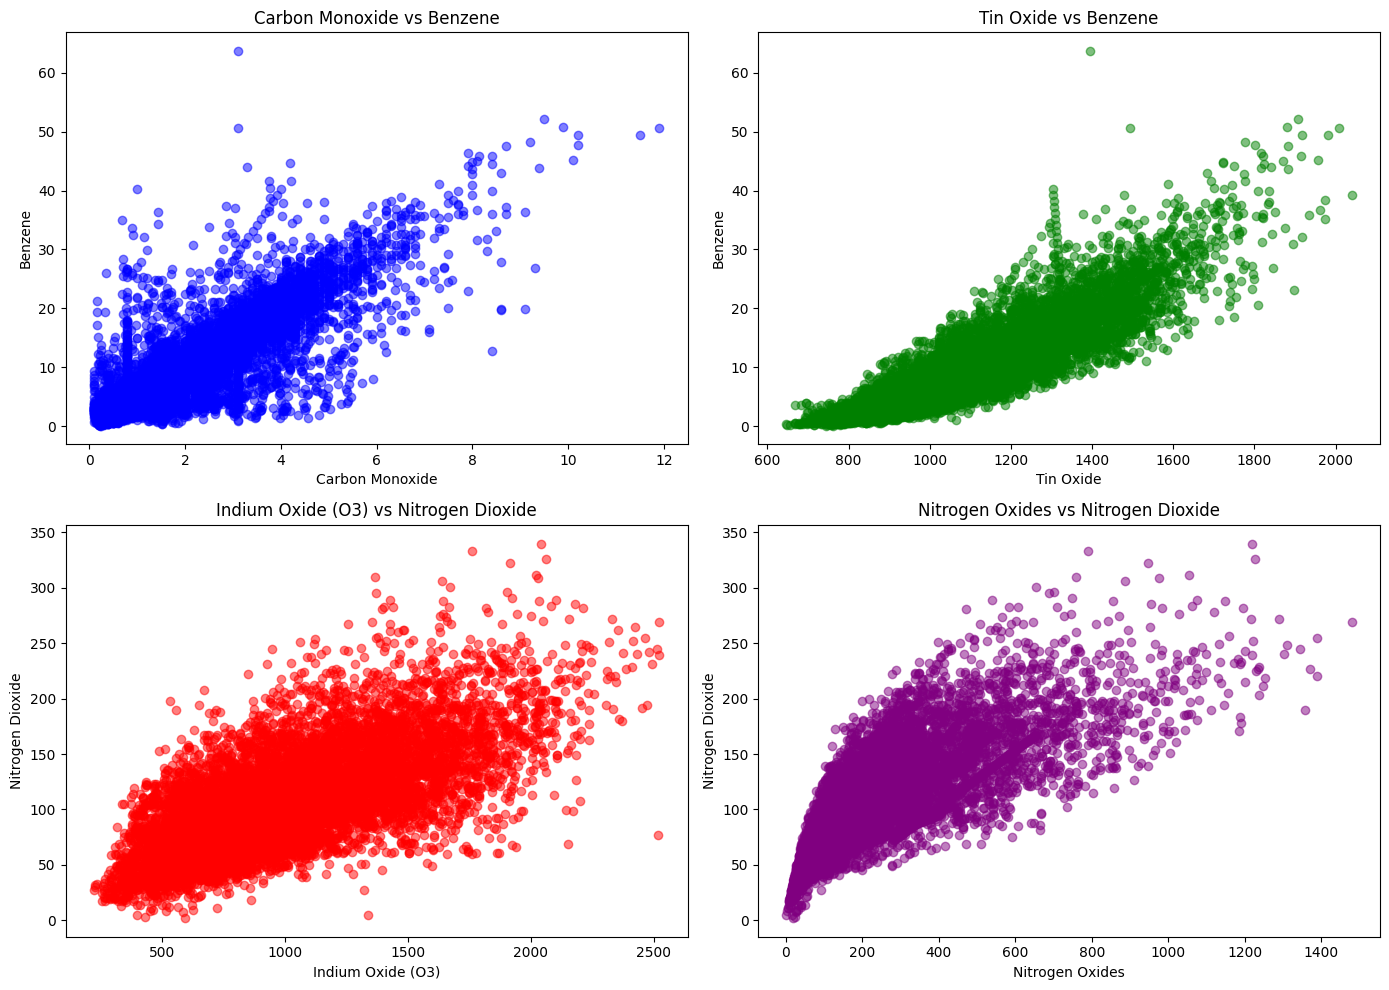

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Carbon Monoxide and Benzene
axes[0, 0].scatter(air_quality_data1['Carbon Monoxide'], air_quality_data1['Benzene'], color='blue', alpha=0.5)
axes[0, 0].set_title('Carbon Monoxide vs Benzene')
axes[0, 0].set_xlabel('Carbon Monoxide')
axes[0, 0].set_ylabel('Benzene')

# Tin Oxide and Benzene
axes[0, 1].scatter(air_quality_data1['Tin Oxide'], air_quality_data1['Benzene'], color='green', alpha=0.5)
axes[0, 1].set_title('Tin Oxide vs Benzene')
axes[0, 1].set_xlabel('Tin Oxide')
axes[0, 1].set_ylabel('Benzene')

# Indium Oxide (O3) and Nitrogen Dioxide
axes[1, 0].scatter(air_quality_data1['Indium Oxide (O3)'], air_quality_data1['Nitrogen Dioxide'], color='red', alpha=0.5)
axes[1, 0].set_title('Indium Oxide (O3) vs Nitrogen Dioxide')
axes[1, 0].set_xlabel('Indium Oxide (O3)')
axes[1, 0].set_ylabel('Nitrogen Dioxide')

# Nitrogen Oxides and Nitrogen Dioxide
axes[1, 1].scatter(air_quality_data1['Nitrogen Oxides'], air_quality_data1['Nitrogen Dioxide'], color='purple', alpha=0.5)
axes[1, 1].set_title('Nitrogen Oxides vs Nitrogen Dioxide')
axes[1, 1].set_xlabel('Nitrogen Oxides')
axes[1, 1].set_ylabel('Nitrogen Dioxide')

plt.tight_layout()
plt.show()

Observations:-

- Carbon Monoxide vs Benzene: Shows a dispersed but positive trend, suggesting as Carbon Monoxide levels increase, Benzene levels tend to increase as well.
- Tin Oxide vs Benzene: Displays a more defined positive correlation, indicating a strong relationship between the two. As Tin Oxide levels rise, so do Benzene levels.
- Indium Oxide (O3) vs Nitrogen Dioxide: This plot also shows a positive trend, albeit with a wide spread of data points, suggesting variability in how these two pollutants relate.
- Nitrogen Oxides vs Nitrogen Dioxide: Exhibits a clear positive correlation, indicating a strong linear relationship between the concentrations of Nitrogen Oxides and Nitrogen Dioxide

### 5 - Pairplot

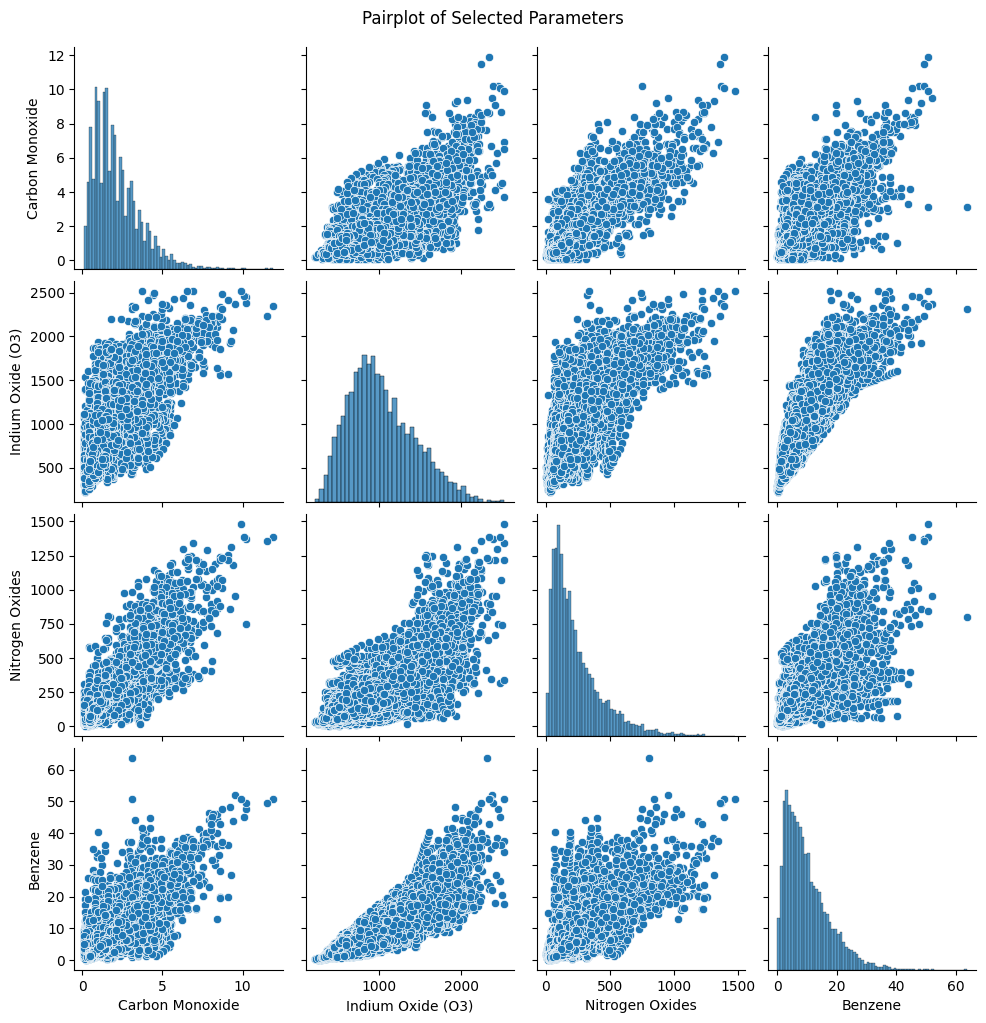

In [ ]:
subset_df = air_quality_data1[['Carbon Monoxide', 'Indium Oxide (O3)', 'Nitrogen Oxides', 'Benzene']]

sns.pairplot(subset_df)
plt.suptitle("Pairplot of Selected Parameters", y=1.02)
plt.show()

Observations:-

- Diagonal plots show the distribution of each variable, giving us insight into their individual characteristics.
- Scatter plots reveal how the variables relate to each other. For example, the scatter plot between 'Carbon Monoxide' and 'Benzene' shows a positive trend, indicating that higher levels of one are associated with higher levels of the other. This pattern is consistent with the earlier analysis of their correlation.
- Patterns and outliers can also be identified through this visualization. For instance, we can see the range of values that most data points fall into and spot any data points that deviate significantly from these range

### 6 - Density plots

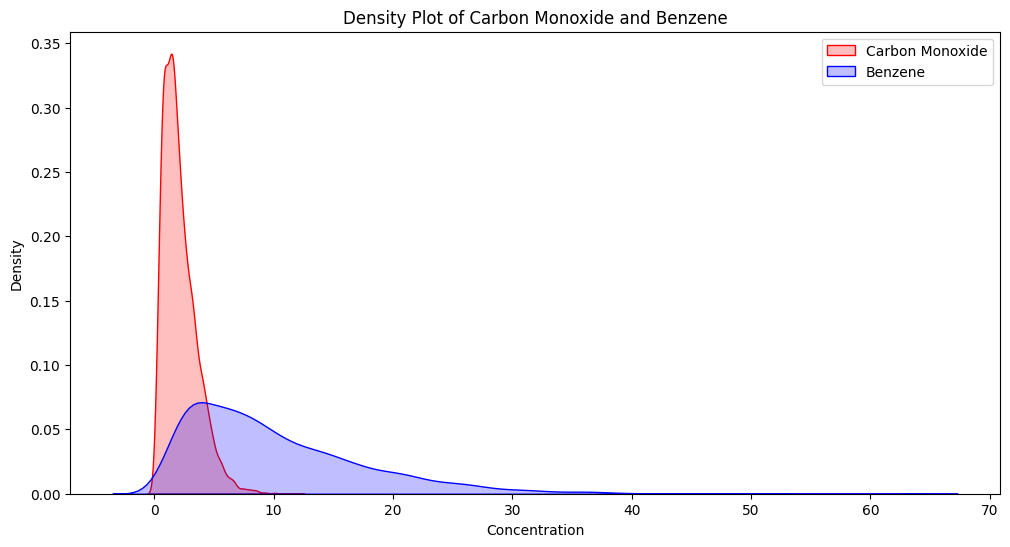

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(air_quality_data1['Carbon Monoxide'], fill=True, color="r", label='Carbon Monoxide')
sns.kdeplot(air_quality_data1['Benzene'], fill=True, color="b", label='Benzene')
plt.title('Density Plot of Carbon Monoxide and Benzene')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

Observations:-
- Shape of the Distribution: The plot suggests that both 'Carbon Monoxide' and 'Benzene' have right-skewed distributions, meaning most of the data points are concentrated on the left side of the plot, with a tail stretching towards the right. This indicates that lower concentrations are more common than higher concentrations for both pollutants.
- Comparison of Spread: 'Carbon Monoxide' appears to have a narrower spread compared to 'Benzene', suggesting that 'Carbon Monoxide' concentrations vary less and are more concentrated around their common values than 'Benzene'.

### 7 - Violin plots

<ipython-input-60-20d114c497f3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=air_quality_data1, y='Carbon Monoxide', ax=axes[0, 0], palette="muted")
<ipython-input-60-20d114c497f3>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=air_quality_data1, y='Indium Oxide (O3)', ax=axes[0, 1], palette="muted")
<ipython-input-60-20d114c497f3>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=air_quality_data1, y='Nitrogen Oxides', ax=axes[1, 0], palette="muted")
<ipython-input-60-20d114c497f3>:16: FutureWarning: 

Passing 

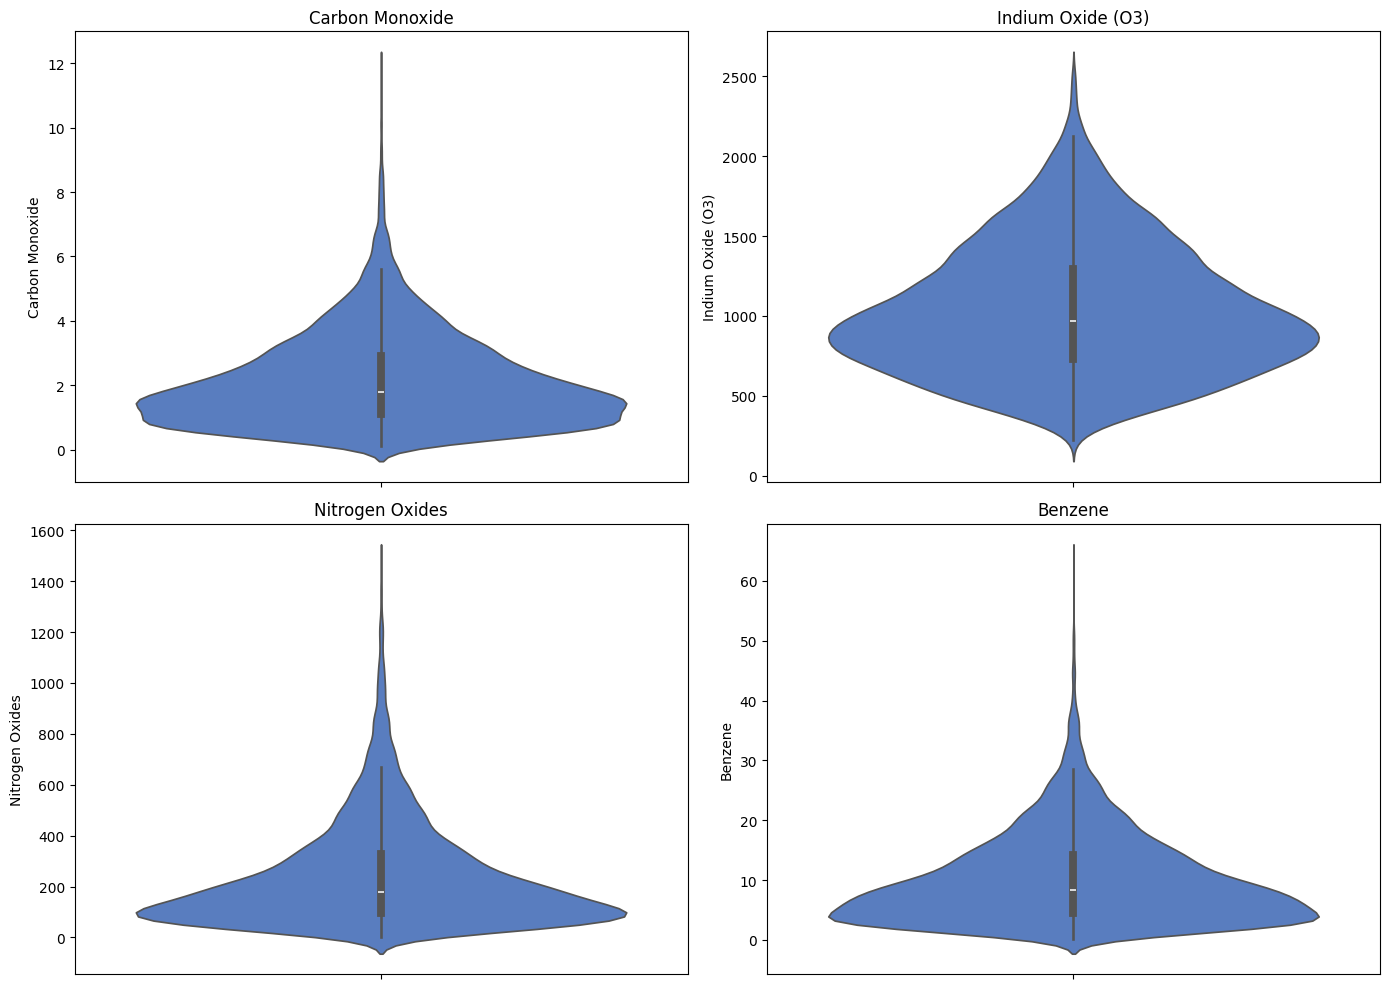

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Carbon Monoxide
sns.violinplot(data=air_quality_data1, y='Carbon Monoxide', ax=axes[0, 0], palette="muted")
axes[0, 0].set_title('Carbon Monoxide')

# Indium Oxide (O3)
sns.violinplot(data=air_quality_data1, y='Indium Oxide (O3)', ax=axes[0, 1], palette="muted")
axes[0, 1].set_title('Indium Oxide (O3)')

# Nitrogen Oxides
sns.violinplot(data=air_quality_data1, y='Nitrogen Oxides', ax=axes[1, 0], palette="muted")
axes[1, 0].set_title('Nitrogen Oxides')

# Benzene
sns.violinplot(data=air_quality_data1, y='Benzene', ax=axes[1, 1], palette="muted")
axes[1, 1].set_title('Benzene')

plt.tight_layout()
plt.show()

Observations:-
- Carbon Monoxide: The violin plot shows a distribution that is skewed towards lower values with a long tail towards higher values, indicating most of the observations are low with a few higher outliers. The thickness of the plot indicates a higher density of values around the lower end.

- Indium Oxide (O3): This plot also shows a skewed distribution towards lower values but with a less pronounced tail compared to Carbon Monoxide. The distribution is slightly wider in the middle, suggesting a broader range of common values.

- Nitrogen Oxides: The distribution is quite wide, indicating a large variability in the Nitrogen Oxides data. Like the others, it's skewed towards lower values, with a tail indicating occasional higher values.

- Benzene: Similar to the others, Benzene shows a skewed distribution with most of the data concentrated at lower concentrations and a tail stretching towards higher concentrations. The plot suggests a high density of low values and the presence of outliers or extreme values at the higher end.

### 8 - Bar plots

Let's assume the following arbitrary thresholds for categorization-

- Carbon Monoxide: Low (<= 1.5), Medium (> 1.5 and <= 3), High (> 3)
- Benzene: Low (<= 3), Medium (> 3 and <= 10), High (> 10)
- Indium Oxide (O3): Low (<= 800), Medium (> 800 and <= 1400), High (> 1400)
- Nitrogen Oxides: Low (<= 100), Medium (> 100 and <= 200), High (> 200)

<ipython-input-61-55aea5f78b96>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=air_quality_data1['CO_Category'].value_counts().sort_index().index,
<ipython-input-61-55aea5f78b96>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=air_quality_data1['Benzene_Category'].value_counts().sort_index().index,
<ipython-input-61-55aea5f78b96>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=air_quality_data1['IO3_Category'].value_counts().sort_index().index,
<ipython-input-61-55aea5f78b96>:33: FutureWarning: 

Passing `palette` without assigni

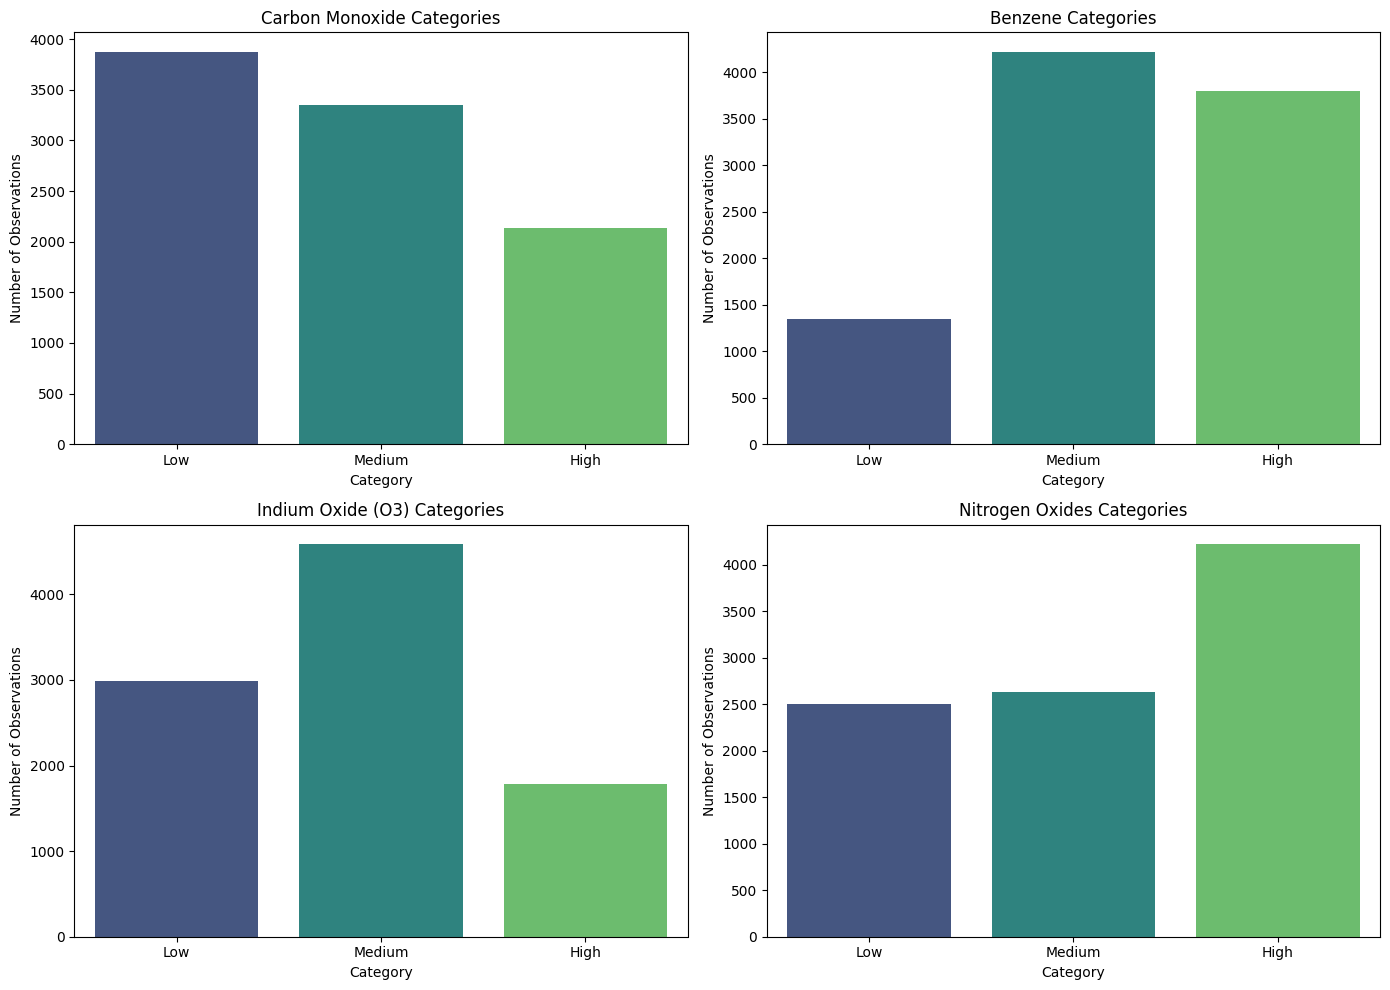

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

air_quality_data1['CO_Category'] = pd.cut(air_quality_data1['Carbon Monoxide'],bins=[-float('inf'), 1.5, 3, float('inf')],labels=['Low', 'Medium', 'High'])
air_quality_data1['Benzene_Category'] = pd.cut(air_quality_data1['Benzene'], bins=[-float('inf'), 3, 10, float('inf')], labels=['Low', 'Medium', 'High'])
air_quality_data1['IO3_Category'] = pd.cut(air_quality_data1['Indium Oxide (O3)'], bins=[-float('inf'), 800, 1400, float('inf')], labels=['Low', 'Medium', 'High'])
air_quality_data1['NOx_Category'] = pd.cut(air_quality_data1['Nitrogen Oxides'], bins=[-float('inf'), 100, 200, float('inf')], labels=['Low', 'Medium', 'High'])
# Plotting each parameter's categories in its respective subplot
# Carbon Monoxide
sns.barplot(x=air_quality_data1['CO_Category'].value_counts().sort_index().index,
            y=air_quality_data1['CO_Category'].value_counts().sort_index().values,
            palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title('Carbon Monoxide Categories')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Number of Observations')

# Benzene
sns.barplot(x=air_quality_data1['Benzene_Category'].value_counts().sort_index().index,
            y=air_quality_data1['Benzene_Category'].value_counts().sort_index().values,
            palette="viridis", ax=axes[0, 1])
axes[0, 1].set_title('Benzene Categories')
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('Number of Observations')

# Indium Oxide (O3)
sns.barplot(x=air_quality_data1['IO3_Category'].value_counts().sort_index().index,
            y=air_quality_data1['IO3_Category'].value_counts().sort_index().values,
            palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('Indium Oxide (O3) Categories')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Number of Observations')

# Nitrogen Oxides
sns.barplot(x=air_quality_data1['NOx_Category'].value_counts().sort_index().index,
            y=air_quality_data1['NOx_Category'].value_counts().sort_index().values,
            palette="viridis", ax=axes[1, 1])
axes[1, 1].set_title('Nitrogen Oxides Categories')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Number of Observations')

plt.tight_layout()
plt.show()


Observations:-

- Carbon Monoxide: The prevalence of lower concentrations suggests better air quality conditions most of the time, with occasional increases that might require attention or action.
- Benzene: A large number of observations fall into the 'Medium' category, followed by a significant number in the 'High' category. The 'Low' category has the fewest observations. This suggests that Benzene levels are often found in medium to high concentrations in this dataset.
- Indium Oxide (O3): The 'Medium' category contains the most observations, indicating that Indium Oxide (O3) levels commonly fall within this range. The 'Low' category follows, with fewer observations, and the 'High' category has the least. This distribution suggests a concentration of Indium Oxide (O3) levels in the medium range.
- Nitrogen Oxides: The distribution of Nitrogen Oxides is relatively balanced between the 'Medium' and 'High' categories, with both having a large number of observations. The 'Low' category has fewer observations. This indicates that Nitrogen Oxides levels are frequently found in medium to high concentrations.

### 9 - Line plots

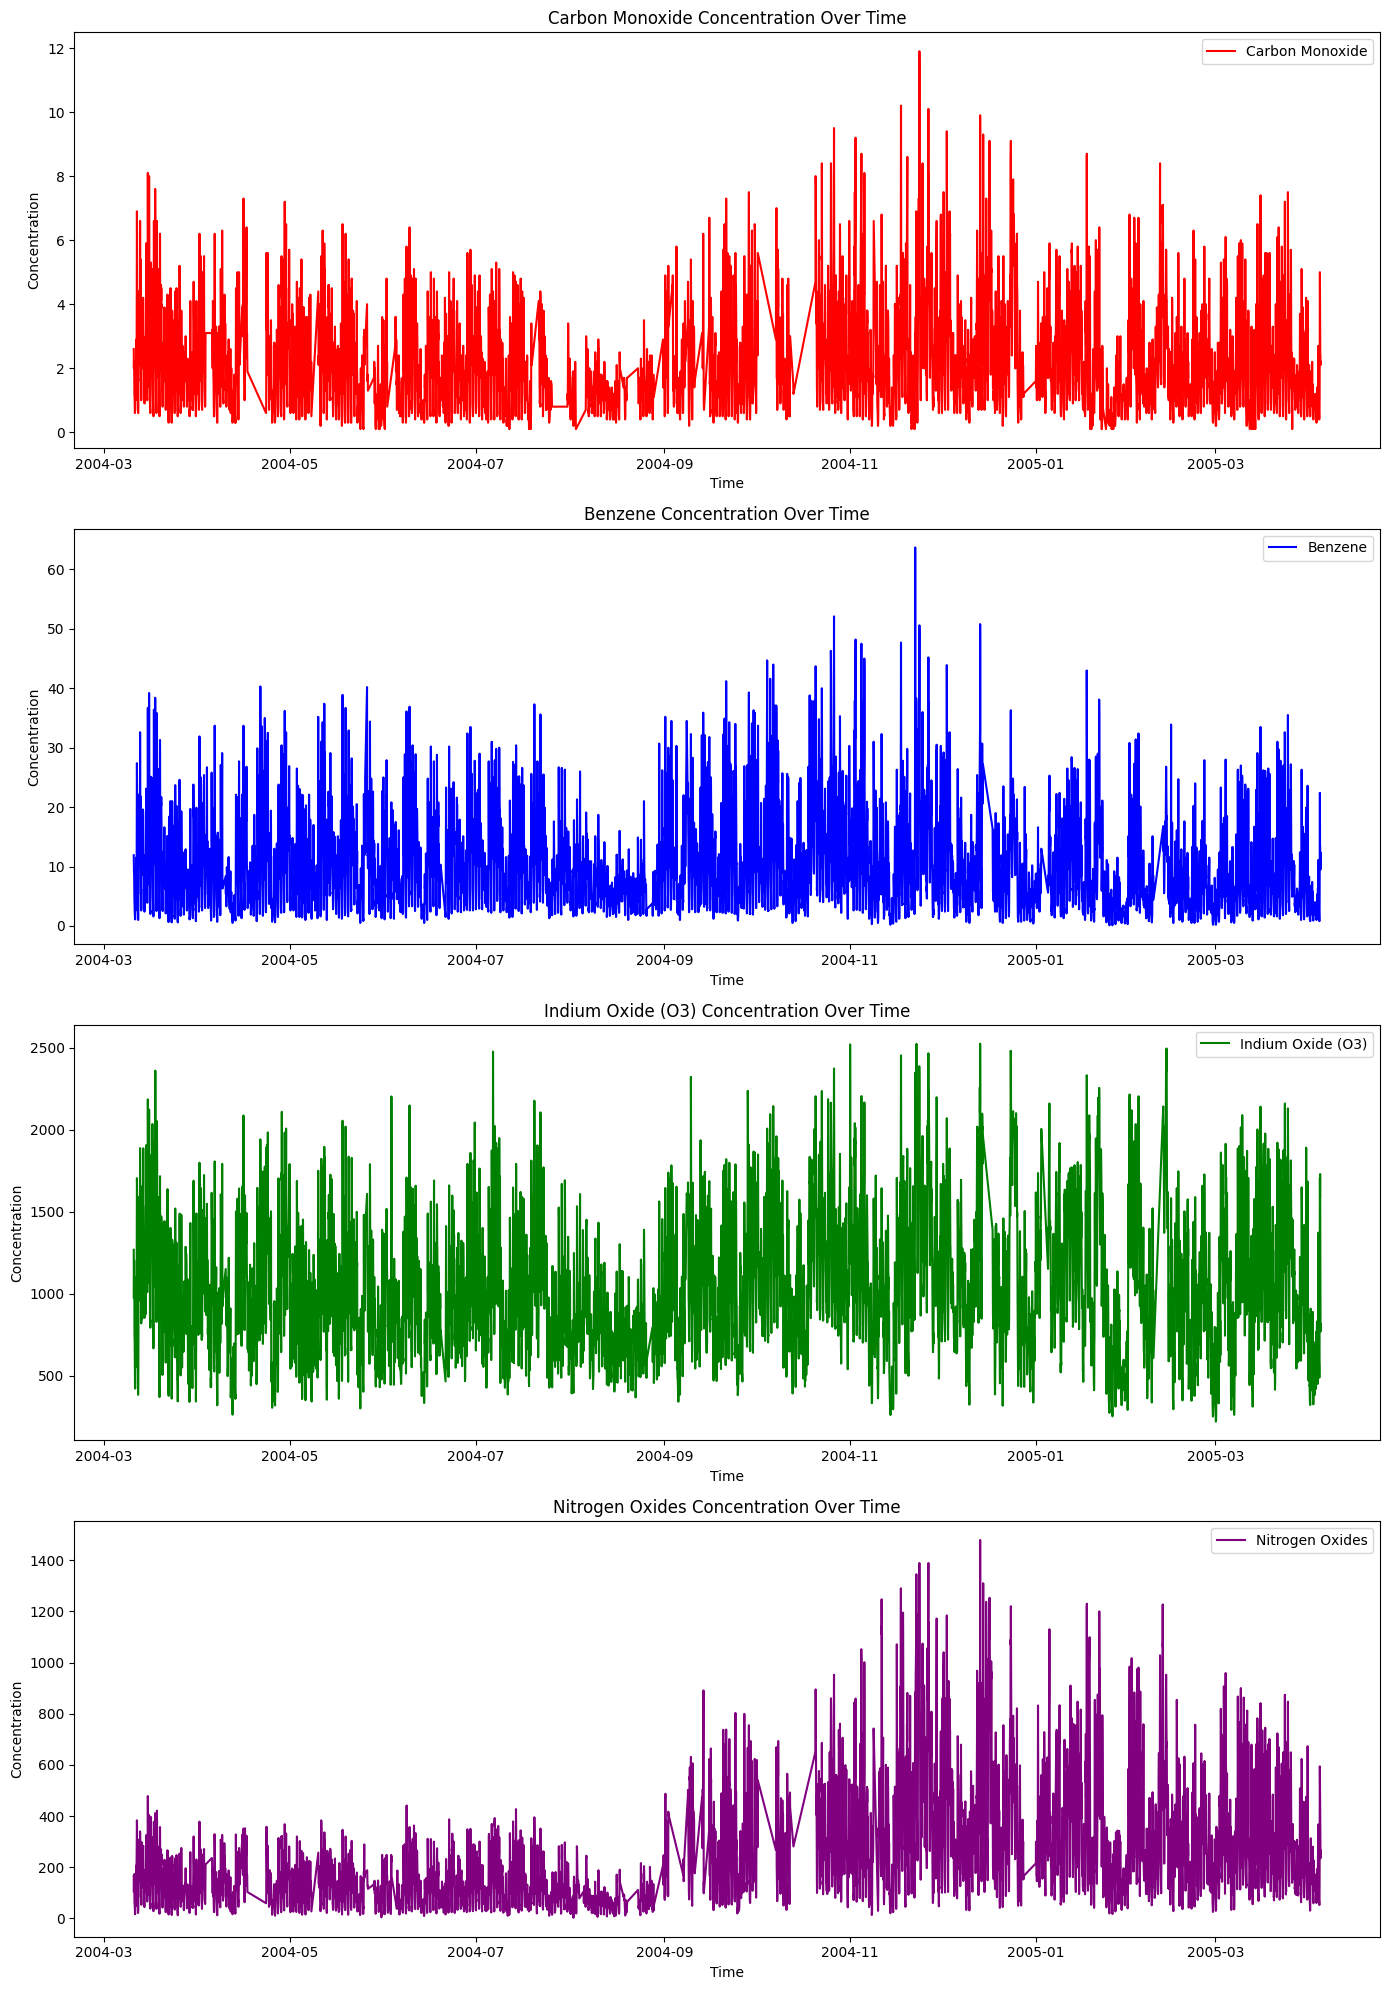

In [ ]:
air_quality_data['DateTime'] = pd.to_datetime(air_quality_data['DateTime'])

fig, axes = plt.subplots(4, 1, figsize=(14, 20))

# Carbon Monoxide over time
axes[0].plot(air_quality_data['DateTime'], air_quality_data['Carbon Monoxide'], color='red', label='Carbon Monoxide')
axes[0].set_title('Carbon Monoxide Concentration Over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[0].legend()

# Benzene over time
axes[1].plot(air_quality_data['DateTime'], air_quality_data['Benzene'], color='blue', label='Benzene')
axes[1].set_title('Benzene Concentration Over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Concentration')
axes[1].legend()

# Indium Oxide (O3) over time
axes[2].plot(air_quality_data['DateTime'], air_quality_data['Indium Oxide (O3)'], color='green', label='Indium Oxide (O3)')
axes[2].set_title('Indium Oxide (O3) Concentration Over Time')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Concentration')
axes[2].legend()

# Nitrogen Oxides over time
axes[3].plot(air_quality_data['DateTime'], air_quality_data['Nitrogen Oxides'], color='purple', label='Nitrogen Oxides')
axes[3].set_title('Nitrogen Oxides Concentration Over Time')
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Concentration')
axes[3].legend()

plt.tight_layout()
plt.show()

Observations:-

- Carbon Monoxide: Shows fluctuations over time with periods of relatively higher concentrations. The plot suggests variability in Carbon Monoxide levels, which could be influenced by factors such as traffic patterns, industrial activities, or seasonal changes.

- Benzene: The concentration of Benzene also fluctuates over time, with some peaks indicating periods of higher pollution. Similar to Carbon Monoxide, these variations might be related to human activities or environmental conditions.

- Indium Oxide (O3): The plot shows a wide range of concentrations over time, with some spikes suggesting occasional high levels of O3. The variability could be related to weather conditions, ozone formation processes, or changes in precursor pollutants.

- Nitrogen Oxides: The concentration of Nitrogen Oxides exhibits considerable variability, with several peaks indicating episodes of high pollution. These fluctuations could be related to traffic, industrial emissions, and the interplay with atmospheric conditions that affect NOx levels.

### 10 - 3D Scatter plot

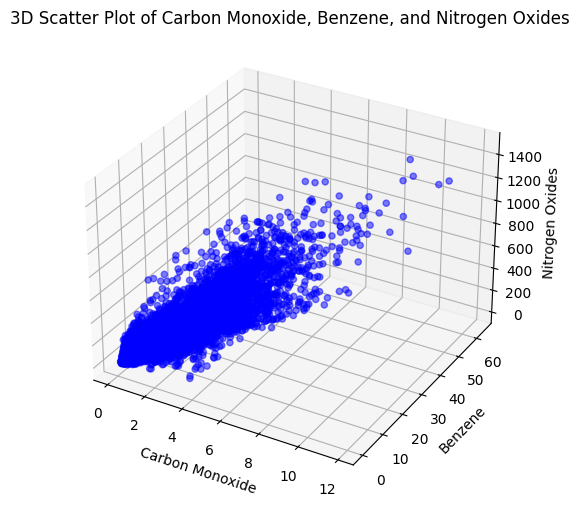

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Creating a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting data
ax.scatter(air_quality_data1['Carbon Monoxide'], air_quality_data1['Benzene'], air_quality_data1['Nitrogen Oxides'], c='blue', alpha=0.5)

# Setting labels
ax.set_xlabel('Carbon Monoxide')
ax.set_ylabel('Benzene')
ax.set_zlabel('Nitrogen Oxides')

# Title
ax.set_title('3D Scatter Plot of Carbon Monoxide, Benzene, and Nitrogen Oxides')

plt.show()


Observations:-
- There appears to be a broad distribution of 'Nitrogen Oxides' across a wide range of 'Carbon Monoxide' and 'Benzene' concentrations. This might indicate that 'Nitrogen Oxides' levels are influenced by factors other than just the levels of 'Carbon Monoxide' and 'Benzene', or that its sources are more varied.
- The data points extend more significantly along the 'Nitrogen Oxides' axis, suggesting that variations in 'Nitrogen Oxides' are more pronounced compared to the variations in 'Carbon Monoxide' and 'Benzene'

## Implementing Models

Considering the columns that are required for modelling and ignoring the extra columns that were generated during data visualization. Here our target variable is O3_AQI.

In [ ]:
air_quality_data1

,Carbon Monoxide,Tin Oxide,Benzene,Titania,Nitrogen Oxides,Tungsten Oxide (NOx targeted),Nitrogen Dioxide,Tungsten Oxide (NO2 targeted),Indium Oxide (O3),Relative Humidity (%),Absolute Humidity,O3_AQI,CO_Category,Benzene_Category,IO3_Category,NOx_Category
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,135,Medium,High,Medium,Medium
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,115,Medium,Medium,Medium,Medium
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,122,Medium,Medium,Medium,Medium
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,130,Medium,Medium,Medium,Medium
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,124,Medium,Medium,Medium,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,29.3,0.7568,161,High,High,High,High
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,23.7,0.7119,135,Medium,High,Medium,High
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,18.3,0.6406,123,Medium,High,Medium,High
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,13.5,0.5139,101,Medium,Medium,Low,High


In [ ]:
air_quality_data1.columns

Index(['Carbon Monoxide', 'Tin Oxide', 'Benzene', 'Titania', 'Nitrogen Oxides',
       'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity', 'O3_AQI', 'CO_Category',
       'Benzene_Category', 'IO3_Category', 'NOx_Category'],
      dtype='object')

In [ ]:
air_quality=air_quality_data1[['Carbon Monoxide', 'Tin Oxide', 'Benzene', 'Titania', 'Nitrogen Oxides',
       'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity', 'O3_AQI']]

In [ ]:
# Since the target variable is continuos variiable we are converting into categories based on the AQI indexes available on web
bins = [0, 50, 100, 200,250]
labels = ['Good', 'Satisfactory', 'Moderately polluted','Poor']
air_quality['AQI_Category'] = pd.cut(air_quality['O3_AQI'], bins=bins, labels=labels, include_lowest=True)

air_quality.head()

<ipython-input-33-02be4668e9e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality['AQI_Category'] = pd.cut(air_quality['O3_AQI'], bins=bins, labels=labels, include_lowest=True)


,Carbon Monoxide,Tin Oxide,Benzene,Titania,Nitrogen Oxides,Tungsten Oxide (NOx targeted),Nitrogen Dioxide,Tungsten Oxide (NO2 targeted),Indium Oxide (O3),Relative Humidity (%),Absolute Humidity,O3_AQI,AQI_Category
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,135,Moderately polluted
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,115,Moderately polluted
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,122,Moderately polluted
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,130,Moderately polluted
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,124,Moderately polluted


In [ ]:
air_quality.columns

Index(['Carbon Monoxide', 'Tin Oxide', 'Benzene', 'Titania', 'Nitrogen Oxides',
       'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity', 'O3_AQI', 'AQI_Category'],
      dtype='object')

In [ ]:
air_quality[['AQI_Category']].value_counts()

AQI_Category       
Moderately polluted    6781
Satisfactory           2145
Good                    427
Poor                      4
Name: count, dtype: int64

In [ ]:
#As the target variable is supposed to be numerical we are replacing the string values
air_quality['AQI_Category'] = air_quality['AQI_Category'].replace(to_replace=['Good','Satisfactory','Moderately polluted','Poor'],value=[0,1,2,3])

<ipython-input-33-e8e880c03948>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality['AQI_Category'] = air_quality['AQI_Category'].replace(to_replace=['Good','Satisfactory','Moderately polluted','Poor'],value=[0,1,2,3])


In [ ]:
#final dataframe for modelling
air_quality[['Carbon Monoxide', 'Tin Oxide', 'Benzene', 'Titania', 'Nitrogen Oxides',
       'Tungsten Oxide (NOx targeted)', 'Nitrogen Dioxide',
       'Tungsten Oxide (NO2 targeted)', 'Indium Oxide (O3)',
       'Relative Humidity (%)', 'Absolute Humidity', 'AQI_Category']]

,Carbon Monoxide,Tin Oxide,Benzene,Titania,Nitrogen Oxides,Tungsten Oxide (NOx targeted),Nitrogen Dioxide,Tungsten Oxide (NO2 targeted),Indium Oxide (O3),Relative Humidity (%),Absolute Humidity,AQI_Category
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,2
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,2
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,2
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,2
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,29.3,0.7568,2
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,23.7,0.7119,2
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,18.3,0.6406,2
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,13.5,0.5139,2


In [ ]:
X = air_quality.drop('AQI_Category', axis = 1).values
y = air_quality['AQI_Category'].values

In [ ]:
#splitting the train and test data into 70% and 30% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [ ]:
#Using standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
lr_train_acc = lr.score(X_train, y_train)
print('Training Score: ', lr_train_acc)
lr_test_acc = lr.score(X_test, y_test)
print('Testing Score: ', lr_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       132
           1       0.99      0.95      0.97       638
           2       0.99      1.00      0.99      2036
           3       0.00      0.00      0.00         2

    accuracy                           0.99      2808
   macro avg       0.74      0.73      0.74      2808
weighted avg       0.99      0.99      0.99      2808

Confusion Matrix: 
 [[ 130    2    0    0]
 [   4  609   25    0]
 [   0    2 2034    0]
 [   0    0    2    0]]
Training Score:  0.990990990990991
Testing Score:  0.9875356125356125


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

 The confusion matrix demonstrates that the majority of cases are correctly classified, with very few cases being misclassified. With an accuracy of 0.99, the model predicts the classes accurately in 99% of the cases.

 The class-wise metrics demonstrate good sensitivity in identifying positive instances of these classes, with high recall values of 0.98 for class 0 and 1.0 for class 2. Class 0 and class 2 precision ratings of 0.97 and 0.99, respectively, are  likewise high, indicating that the model produces relatively few false positive predictions for these classes.

 With a training accuracy of 0.99099099099099091, the model was able to learn the training set. Moreover, the testing accuracy of 0.9875356125356125 is rather high, indicating strong generalisation to unobserved data.The macro average F1-score of 0.74 indicates a decent overall performance across classes.

## SVM without parameters

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
svc_train_acc = svc.score(X_train, y_train)
print('Training Score: ', svc_train_acc)
svc_test_acc = svc.score(X_test, y_test)
print('Testing Score: ', svc_test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       132
           1       0.97      0.91      0.94       638
           2       0.98      1.00      0.99      2036
           3       0.00      0.00      0.00         2

    accuracy                           0.97      2808
   macro avg       0.71      0.70      0.70      2808
weighted avg       0.97      0.97      0.97      2808

Confusion Matrix: 
 [[ 119   13    0    0]
 [  17  578   43    0]
 [   0    5 2031    0]
 [   0    0    2    0]]
Training Score:  0.9806077263704382
Testing Score:  0.9715099715099715


While there are some misclassifications shown in the confusion matrix, most occurrences are correctly predicted. With an accuracy of 0.97, the model is capable of predicting the classes in 97% of the cases.

Class-wise metrics provide good sensitivity in identifying positive instances of these classes, with high recall values of 0.90 for class 0 and 1.0 for class 2. Class 0 and class 2 precision ratings of 0.88 and 0.98, respectively, are likewise rather good, indicating that the model produces relatively few false positive predictions for these classes.

The accuracy values for testing (0.971501915099715) and training (0.9806077263704382) are also quite high. With a macro average F1-score of 0.70, the performance seemed to be quite good.


## SVM with hyperparameter tuning

In [ ]:
svc = SVC(C = 1, gamma= 1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
svc_train_acc = svc.score(X_train, y_train)
print('Training Score: ', svc_train_acc)
svc_test_acc = svc.score(X_test, y_test)
print('Testing Score: ', svc_test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       132
           1       0.96      0.89      0.92       638
           2       0.97      1.00      0.98      2036
           3       0.00      0.00      0.00         2

    accuracy                           0.96      2808
   macro avg       0.70      0.69      0.70      2808
weighted avg       0.96      0.96      0.96      2808

Confusion Matrix: 
 [[ 116   13    3    0]
 [  16  566   56    0]
 [   0   10 2026    0]
 [   0    0    2    0]]
Training Score:  0.9888532600397008
Testing Score:  0.9643874643874644


C=1 and gamma=1 are used as hyperparameters to the SVC model. While there are some incorrect categories in the confusion matrix, most cases are appropriately classified. With an accuracy of 0.96, the model predicts the classes accurately in 96% of the cases.

High recall scores of 0.88 for class 0, 0.89 for class 1, and 1.0 for class 2 are displayed by the class-wise metrics, demonstrating good sensitivity in identifying positive instances of these classes. According to high precision values of 0.88 for class 0, 0.96 for class 1, and 0.97 for class 2, the model appears to make quite few flase positive predictions for these classes. The testing accuracy is 0.9643874643874644 and training accuracy is 0.9888532600397008.

The macro average F1-score of 0.70 is similar to the previous SVC model. The hyperparameter tuning seems to have slightly improved the performance compared to the default SVC model.

## KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
knn_train_acc = knn.score(X_train, y_train)
print('Training Score: ', knn_train_acc)
knn_test_acc = knn.score(X_test, y_test)
print('Testing Score: ', knn_test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       132
           1       0.91      0.87      0.89       638
           2       0.97      0.98      0.98      2036
           3       0.00      0.00      0.00         2

    accuracy                           0.95      2808
   macro avg       0.68      0.67      0.68      2808
weighted avg       0.95      0.95      0.95      2808

Confusion Matrix: 
 [[ 111   21    0    0]
 [  20  553   65    0]
 [   0   35 2001    0]
 [   0    0    2    0]]
Training Score:  0.970987937089632
Testing Score:  0.9490740740740741


The K-Nearest Neighbors (KNN) Classifier was implemented without any specific hyperparameter tuning mentioned.

From the classification report, the KNN model achieved decent performance for classes 0, 1, and 2, with precision values of 0.85, 0.91, and 0.97, respectively. However, similar to the previous models, it failed to correctly classify any instances of class 3, resulting in a precision of 0.00 for that class.

The confusion matrix shows that a significant number of instances were misclassified across classes 0, 1, and 2. For example, 21 instances of class 0 were misclassified as class 1, and 65 instances of class 1 were misclassified as class 2.

The training score of 0.9708793708796323 indicates that the model was able to fit the training data reasonably well, but there is still room for improvement. The testing score of 0.9490740740740741 suggests some overfitting, as the model did not generalize as well to the unseen test data.

In terms of evaluation metrics, the KNN model achieved an accuracy of 0.95 on the test set, which is lower than the previous models. The macro average precision, recall, and F1-score were 0.68, 0.67, and 0.68, respectively, reflecting the challenges in correctly classifying all classes. The weighted average precision, recall, and F1-score were 0.95, reflecting the influence of the more prevalent classes.

## KNN with hyperparameters

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 31)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
knn_train_acc = knn.score(X_train, y_train)
print('Training Score: ', knn_train_acc)
knn_test_acc = knn.score(X_test, y_test)
print('Testing Score: ', knn_test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79       132
           1       0.91      0.84      0.87       638
           2       0.96      0.99      0.98      2036
           3       0.00      0.00      0.00         2

    accuracy                           0.94      2808
   macro avg       0.67      0.65      0.66      2808
weighted avg       0.94      0.94      0.94      2808

Confusion Matrix: 
 [[ 102   30    0    0]
 [  24  538   76    0]
 [   0   24 2012    0]
 [   0    0    2    0]]
Training Score:  0.9540387845472591
Testing Score:  0.9444444444444444


With n_neighbors=31, the K-Nearest Neighbours Classifier (KNN) is fine-tuned. While certain misclassifications are shown by the confusion matrix, most instances are accurately predicted. With an accuracy of 0.94, the model predicts the classes accurately in 94% of the cases.

The class-wise metrics demonstrate that there is a good sensitivity in identifying positive cases of classes 1 and 2, but a lesser sensitivity for class 0. Recall values for class 0 are 0.77, 0.84, and 0.99, respectively. The model appears to make relatively few false positive predictions for these classes, as indicated by the rather high precision values of 0.81 for class 0, 0.91 for class 1, and 0.96 for class 2. The testing accuracy of 0.944444 and the training accuracy of 0.9540387845472591 are both fairly high.

The macro average F1-score of 0.66 is lower than the other models, indicating a less optimal overall performance. The hyperparameter tuning for the number of neighbors seems to have been performed.

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
dt_train_acc = dt.score(X_train, y_train)
print('Training Score: ', dt_train_acc)
dt_test_acc = dt.score(X_test, y_test)
print('Testing Score: ', dt_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       638
           2       1.00      1.00      1.00      2036
           3       1.00      1.00      1.00         2

    accuracy                           1.00      2808
   macro avg       1.00      1.00      1.00      2808
weighted avg       1.00      1.00      1.00      2808

Confusion Matrix: 
 [[ 132    0    0    0]
 [   0  638    0    0]
 [   0    0 2036    0]
 [   0    0    0    2]]
Training Score:  1.0
Testing Score:  1.0


The Decision Tree Classifier performing at a maximum depth of 5 performs perfectly. The accuracy of the confusion matrix is 1.0, meaning that all cases are accurately predicted by the model, and there are no misclassifications.

Recall and accuracy values of 1.0 are displayed for each class in the class-wise metrics, signifying perfect sensitivity and the absence of erroneous positive predictions. Both the testing and training accuracies are 1.0. Additionally, the macro average F1-score is 1.0, signifying perfect overall performance.For this model, no additional hyperparameter tweaking is required.


## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators= 150, max_depth= 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       638
           2       1.00      1.00      1.00      2036
           3       0.00      0.00      0.00         2

    accuracy                           1.00      2808
   macro avg       0.75      0.75      0.75      2808
weighted avg       1.00      1.00      1.00      2808

Confusion Matrix: 
 [[ 132    0    0    0]
 [   0  638    0    0]
 [   0    0 2036    0]
 [   0    0    2    0]]
Training Score:  1.0
Testing Score:  0.9992877492877493


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There were 150 estimators used in the Random Forest Classifier model, with a maximum depth of 5. The model achieved ideal precision, recall, and F1-score for classes 0, 1, and 2, according to the classification report. But it was unable to accurately categorise any examples of class 3. The confusion matrix indicates to this, showing that every instance of class 3 was incorrectly categorised.

The model was able to properly match the training data, as shown by the training score of 1.0. The model did not generalise as well to the test data that was not visible, as indicated by the testing score of 0.9992877, which shows a minor overfitting.

The model achieved an accuracy of 1.0 on the test set, indicating that it correctly classified all instances except for class 3. The macro average precision, recall, and F1-score were 0.75, which is influenced by the complete failure to correctly classify class 3. The weighted average metrics were all 1.0, giving higher weight to the more prevalent classes.

## XGBoost

In [ ]:
xgb = XGBClassifier(n_estimators = 100, max_depth = 3, subsample = 0.8, colsample_bytree = 0.6, learning_rate = 0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
xgb_train_acc = xgb.score(X_train, y_train)
print('Training Score: ', xgb_train_acc)
xgb_test_acc = xgb.score(X_test, y_test)
print('Testing Score: ', xgb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00       638
           2       1.00      1.00      1.00      2036
           3       0.00      0.00      0.00         2

    accuracy                           1.00      2808
   macro avg       0.75      0.75      0.75      2808
weighted avg       1.00      1.00      1.00      2808

Confusion Matrix: 
 [[ 132    0    0    0]
 [   0  638    0    0]
 [   0    0 2036    0]
 [   0    0    2    0]]
Training Score:  1.0
Testing Score:  0.9992877492877493


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The XGBoost Classifier was implemented with 100 estimators, a maximum depth of 3, a subsampling rate of 0.8, a column subsampling rate of 0.6, and a learning rate of 0.1.

Based on the classification report, the model achieved perfect precision, recall, and F1-score for classes 0, 1, and 2. However, similar to the Random Forest model, it failed to correctly classify any instances of class 3. The confusion matrix confirms this misclassification of class 3 instances.

The training score of 1.0 indicates that the model was able to perfectly fit the training data. The testing score of 0.999287749287749 suggests slight overfitting, similar to the Random Forest model.

In terms of evaluation metrics, the XGBoost model achieved an accuracy of 1.0 on the test set, correctly classifying all instances except for class 3. The macro average precision, recall, and F1-score were 0.75, again influenced by the failure to correctly classify class 3. The weighted average metrics were all 1.0, giving higher weight to the more prevalent classes.

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
x = ['Logistic Regression','SVC', 'KNN', 'Decision Tree','Random Forest','XGBoost']
y1 = [lr_train_acc, svc_train_acc, knn_train_acc, dt_train_acc, rf_train_acc, xgb_train_acc]
y2 = [lr_test_acc, svc_test_acc, knn_test_acc, dt_test_acc, rf_test_acc, xgb_test_acc]

trace1 = go.Bar(x = x, y = y1, name = 'Training Accuracy', marker = dict(color = 'cyan'))
trace2 = go.Bar(x = x, y = y2, name = 'Testing Accuracy', marker = dict(color = 'violet'))
data = [trace1,trace2]
layout = go.Layout(title = 'Accuracy Plot', width = 750)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)